Step 24: PSG (all EMG, EOG, EEG and ECG) features are aggregated by mean, and logistic regression is trained by aggregated data. Model's classification report, confussion matrix, coefficients, K-folds cross-validation and best features are evaluated. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter as counter
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

%matplotlib inline

In [30]:
sns.set()
no_subject = 27 # number of subjects
no_channel = 12 # number of channels
no_columns = 234

file_path = './PSG_features/' # features files path
data = pd.read_csv('PSG_features_12chn.csv') # features files names
file_name = data['fname']
y = pd.read_csv('PSG_dataset.csv')['label']

In [7]:
nfile = 0 # counter for the PSG file selecting
file_sel = 0 # counter for assigning the shape of an array
flag_col = -5 # counter of selection of feature file for artifact removing (flag)
X_agg = np.empty((0, no_columns))

for nsub in range(no_subject):
    sub_len = pd.read_csv(file_path+file_name[file_sel]).shape
    data_con = np.empty((sub_len[0],0))
    
    mean_array = np.empty((0))
    column = np.empty((0))
    file_sel += no_channel
    flag_col += no_channel # for EOG channel flag
    
    for nchn in range(no_channel):
        df_feature = pd.read_csv(file_path+file_name[nfile])
        
        if 'alpha_mean' in df_feature.columns:
            df_feat = df_feature.drop(df_feature[['flag', 'alpha_mean', 'theta_mean', 'delta_mean', 'label']], axis=1) # removing columns from EEG channels
            column = np.append(column, df_feat.columns)
            
        elif 'flag' in df_feature.columns:
            df_feat = df_feature.drop(df_feature[['flag', 'label', 'mean']], axis=1) # removing columns from other PSG channels
            column = np.append(column, df_feat.columns)
            
        else:
            df_feat = df_feature.drop(df_feature[['label', 'mean']], axis=1) # removing columns from other PSG channels
            column = np.append(column, df_feat.columns)
            
        data_con = np.concatenate((data_con, df_feat), axis=1)
        nfile += 1
    
    df = pd.DataFrame(data = data_con, columns=column)
    df['flag'] = pd.read_csv(file_path+file_name[flag_col])['flag']
    df_feat = df[df['flag'] == 0]
    df_feat = df_feat.drop(['flag'], axis=1)
    # aggrepating the features
    for i in range(df_feat.shape[1]):
        mean_array = np.append(mean_array, [np.mean(df_feat.iloc[:,i])])
    X_agg = np.append(X_agg, [mean_array], axis=0)
    
print('shape of features after aggregate: {}' .format(X_agg.shape))

shape of features after aggregate: (27, 234)


0.9948374365136478

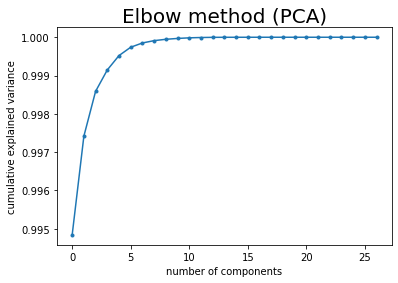

In [8]:
X_pca = PCA()
X_pca.fit_transform(X_agg)
plt.plot(np.cumsum(X_pca.explained_variance_ratio_), '.-')
plt.title('Elbow method (PCA)', fontsize=20)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.max(X_pca.explained_variance_ratio_)

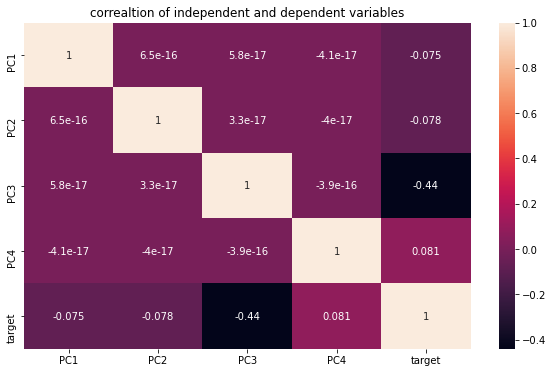

In [9]:
X_scalar = StandardScaler().fit_transform(X_agg)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scalar)
X = StandardScaler().fit_transform(X_pca)

df_p = pd.DataFrame(data=X, columns=['PC1', 'PC2', 'PC3', 'PC4'])#, 'PC5', 'PC6'])
#X = df_p[['comp3', 'comp5']]
df_p['target'] = y
plt.figure(figsize=(10,6))
plt.title('correaltion of independent and dependent variables')
sns.heatmap(df_p.corr(), annot=True)

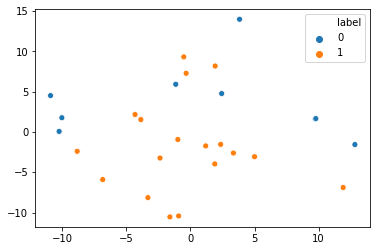

In [10]:
sns.scatterplot(X_pca[:,1], X_pca[:,2], hue=y)

Text(0.5, 1.0, 'scatter plot of 32 subjects')

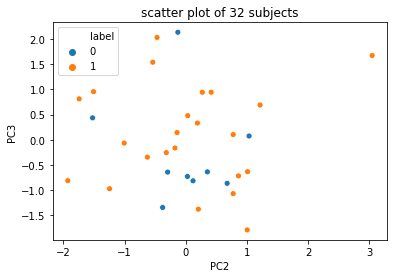

In [11]:
X_l = pd.read_csv('large_dataset_predictors/PSG12_4PC.csv')
y_l = pd.read_csv('large_dataset_predictors/PSG8_3_Clustering.csv')['label']
sns.scatterplot(X_l.iloc[:,1], X_l.iloc[:,2], hue=y_l)
plt.title('scatter plot of 32 subjects')

In [13]:
# merging the datasets

X_merg = np.concatenate((X, X_l), axis=0)
y_merg = np.concatenate((y, y_l))

print('shape of merged data {} and their target labels {}' .format(X_merg.shape, y_merg.shape))

shape of merged data (59, 4) and their target labels (59,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_merg, y_merg, test_size=0.10, random_state=42)

In [33]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model coefficients: [0.31788651 0.23747988 0.17223539 0.25081781]
confusion matrix:
 [[0 2]
 [0 4]] 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



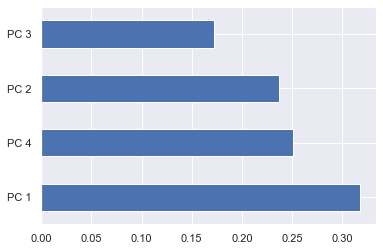

In [38]:
predicted = model.predict(X_test)
print('model coefficients: {}' .format((model.coef_[0]+1)/4))
print(('confusion matrix:\n {} ') .format(confusion_matrix(y_test, predicted)))
print(classification_report(y_test, predicted))
feat_importances = pd.Series((model.coef_[0]+1)/4, index=['PC 1', 'PC 2', 'PC 3', 'PC 4'])
feat_importances.nlargest(4).plot(kind='barh')

In [17]:
predicted = model.predict(X_train)
print(('confusion matrix:\n {} ') .format(confusion_matrix(y_train, predicted)))
print(classification_report(y_train, predicted))

confusion matrix:
 [[ 1 15]
 [ 0 37]] 
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        16
           1       0.71      1.00      0.83        37

    accuracy                           0.72        53
   macro avg       0.86      0.53      0.47        53
weighted avg       0.80      0.72      0.62        53



In [18]:
k_fold = KFold(n_splits=10)
accuracy_array = []

LR = LogisticRegression(random_state=0)
for k, (train, test) in enumerate(k_fold.split(X_merg, y_merg)):
    LR.fit(X_merg[train], y_merg[train])
    accuracy_array.append(LR.score(X_merg[test], y_merg[test]))
    print('cross validation fold {} result: {}' .format(k, LR.score(X_merg[test], y_merg[test])))
    
print('\naverage accuracy of K-fold: {}' .format(np.mean(accuracy_array)))

cross validation fold 0 result: 0.5
cross validation fold 1 result: 0.5
cross validation fold 2 result: 1.0
cross validation fold 3 result: 0.5
cross validation fold 4 result: 0.5
cross validation fold 5 result: 0.6666666666666666
cross validation fold 6 result: 0.6666666666666666
cross validation fold 7 result: 0.5
cross validation fold 8 result: 0.6666666666666666
cross validation fold 9 result: 1.0

average accuracy of K-fold: 0.65


In [19]:
accuracy_average = []
loo = LeaveOneOut()
loo.get_n_splits(X_merg)
i = 0

for train, test in loo.split(X_merg):
    
    LR.fit(X_merg[train], y_merg[train])
    accuracy_average.append(LR.score(X_merg[test], y_merg[test]))
    #print('cross validation fold {} result: {}' .format(i, LR.score(X_merg[test], y_merg[test])))
    i += 1
    
print('\naverage accuracy of one leave out CV: {}' .format(np.mean(accuracy_average)))

warnings.filterwarnings('ignore', category=UserWarning, append=True)


average accuracy of one leave out CV: 0.6949152542372882


[0.24642899 0.36772617 0.27919682 0.10664803]


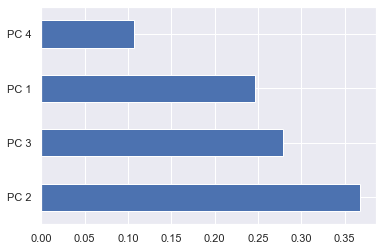

In [31]:
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
# https://scikit-learn.org/stable/modules/feature_selection.html

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=['PC 1', 'PC 2', 'PC 3', 'PC 4'])
feat_importances.nlargest(4).plot(kind='barh')
plt.show()

In [28]:
#https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html
# analysing the features contibution

loadings = pd.DataFrame(np.abs(pca.components_.T) , columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df_feat.columns)
loadings.head()

PC1       PC2       PC3       PC4
alpha_std       0.118869  0.061799  0.018733  0.011194
alpha_energy    0.118079  0.059737  0.010377  0.014295
alpha_variance  0.118079  0.059737  0.010377  0.014294
alpha_skewness  0.029262  0.028169  0.019816  0.071339
alpha_Kurtosis  0.077003  0.026862  0.037369  0.024172

In [29]:
pd.set_option('display.max_rows', loadings.shape[0]+1)
loadings.sort_values(by='PC1', ascending=False)

PC1       PC2       PC3       PC4
alpha_energy          0.123657  0.039172  0.033044  0.014549
alpha_variance        0.123657  0.039172  0.033044  0.014549
alpha_entropy         0.122882  0.010699  0.014068  0.045577
alpha_std             0.122420  0.047708  0.029631  0.011610
alpha_variance        0.121853  0.052050  0.009342  0.010430
alpha_energy          0.121853  0.052050  0.009342  0.010430
alpha_complexity      0.121306  0.008778  0.013804  0.033678
alpha_std             0.120740  0.058921  0.002145  0.014137
alpha_std             0.118869  0.061799  0.018733  0.011194
alpha_complexity      0.118418  0.008815  0.031331  0.039865
alpha_std             0.118365  0.060773  0.021477  0.021030
alpha_variance        0.118079  0.059737  0.010377  0.014294
alpha_energy          0.118079  0.059737  0.010377  0.014295
theta_energy          0.117368  0.007906  0.063229  0.006003
theta_variance        0.117368  0.007906  0.063229  0.006003
theta_std             0.116345  0.003647  0.065598  0.004624
alpha_entropy         0.115653  0.013717  0.023772  0.033050
alpha_std             0.115104  0.057233  0.036171  0.002709
alpha_variance        0.113613  0.046850  0.047587  0.011216
alpha_energy          0.113613  0.046850  0.047587  0.011216
delta_std             0.113180  0.051850  0.025322  0.039757
alpha_variance        0.111157  0.054868  0.045955  0.022278
alpha_energy          0.111157  0.054868  0.045955  0.022278
delta_energy          0.110265  0.070686  0.012375  0.032106
delta_variance        0.110264  0.070688  0.012376  0.032105
alpha_entropy         0.108629  0.008913  0.004397  0.057638
delta_energy          0.108562  0.069985  0.000775  0.050687
delta_variance        0.108562  0.069987  0.000774  0.050686
theta_std             0.107911  0.019641  0.080227  0.025216
delta_std             0.107776  0.062566  0.019818  0.064233
theta_std             0.107710  0.007256  0.091188  0.031827
delta_std             0.107658  0.072115  0.007479  0.038915
delta_std             0.107350  0.076474  0.012981  0.028241
delta_std             0.106807  0.062858  0.005970  0.073313
alpha_complexity      0.106801  0.013900  0.078937  0.022012
theta_std             0.106058  0.002492  0.097352  0.024782
delta_energy          0.104623  0.039773  0.012716  0.027975
delta_variance        0.104622  0.039775  0.012718  0.027974
theta_energy          0.103399  0.020088  0.080409  0.046604
theta_variance        0.103399  0.020089  0.080409  0.046604
alpha_complexity      0.103357  0.036655  0.081833  0.022121
theta_energy          0.102989  0.011955  0.092193  0.046728
theta_variance        0.102989  0.011955  0.092193  0.046728
alpha_entropy         0.102919  0.010072  0.042284  0.055971
theta_energy          0.102232  0.008141  0.098683  0.038959
theta_variance        0.102232  0.008141  0.098683  0.038959
theta_std             0.098752  0.007633  0.086029  0.043345
theta_std             0.098665  0.000622  0.109843  0.015985
theta_energy          0.097154  0.003726  0.107853  0.027183
theta_variance        0.097154  0.003726  0.107853  0.027183
delta_energy          0.093864  0.049402  0.060853  0.074678
delta_variance        0.093862  0.049403  0.060854  0.074678
alpha_std             0.093857  0.068475  0.060494  0.015305
delta_power           0.090862  0.017044  0.054140  0.101919
std                   0.090352  0.008235  0.055475  0.049508
alpha_entropy         0.090071  0.026519  0.045249  0.005985
delta_power           0.089900  0.016317  0.043961  0.124841
delta_power           0.088591  0.013759  0.029493  0.129168
delta_std             0.088108  0.066513  0.005519  0.057758
delta_energy          0.087892  0.046622  0.011699  0.087721
delta_variance        0.087891  0.046624  0.011701  0.087720
theta_energy          0.084463  0.011921  0.061883  0.056078
theta_variance        0.084463  0.011921  0.061883  0.056078
theta_power           0.084247  0.042052  0.010687  0.144409
alpha_energy          0.083675  0.057792  0.069610  0.017888
a

In [25]:
loadings.sort_values(by='PC2', ascending=False)

PC1       PC2       PC3       PC4
alpha_relative_power  0.022639  0.146318  0.036165  0.005257
delta_entropy         0.014729  0.144551  0.024674  0.021949
delta_relative_power  0.000195  0.142657  0.043952  0.030162
alpha_relative_power  0.028742  0.142529  0.024471  0.021373
alpha_relative_power  0.015958  0.142378  0.040950  0.028679
alpha_relative_power  0.007177  0.139239  0.062045  0.028299
delta_relative_power  0.008572  0.138763  0.052464  0.052730
delta_entropy         0.025288  0.137839  0.039646  0.006026
delta_entropy         0.037868  0.136904  0.014008  0.010492
delta_relative_power  0.008146  0.136247  0.059812  0.013973
alpha_relative_power  0.023980  0.135274  0.051694  0.018451
delta_entropy         0.022559  0.134109  0.035924  0.025629
delta_entropy         0.003469  0.131396  0.050990  0.020538
delta_entropy         0.035698  0.130905  0.042958  0.028061
delta_relative_power  0.007394  0.130824  0.070584  0.020194
delta_relative_power  0.019096  0.128693  0.040303  0.067721
delta_mobility        0.000820  0.126865  0.005295  0.078436
delta_relative_power  0.033982  0.126508  0.014383  0.040316
delta_mobility        0.002301  0.123694  0.027146  0.060323
complexity            0.016925  0.121866  0.003632  0.090036
alpha_relative_power  0.022001  0.119275  0.080247  0.019099
mobility              0.044183  0.113922  0.035809  0.063898
delta_complexity      0.044020  0.112945  0.010020  0.084513
delta_mobility        0.000892  0.112887  0.022558  0.069305
delta_mobility        0.024370  0.112676  0.041899  0.055008
theta_entropy         0.006811  0.110681  0.096036  0.026199
delta_complexity      0.016090  0.109716  0.008345  0.113283
entropy               0.032061  0.109517  0.064580  0.037698
delta_complexity      0.004728  0.109233  0.026840  0.059708
entropy               0.013633  0.107988  0.009419  0.036042
delta_mobility        0.010529  0.107851  0.043261  0.029876
complexity            0.024371  0.106117  0.002007  0.035592
delta_complexity      0.011106  0.104046  0.002398  0.099167
delta_complexity      0.005159  0.103848  0.011615  0.094928
mobility              0.030771  0.101169  0.015803  0.021373
delta_skewness        0.000719  0.098865  0.005183  0.111769
delta_mobility        0.030222  0.098519  0.042557  0.061898
delta_complexity      0.053547  0.095661  0.031080  0.067833
theta_mobility        0.011170  0.090242  0.066193  0.073925
std                   0.019728  0.086810  0.068689  0.024061
theta_entropy         0.044688  0.084091  0.118515  0.042623
theta_mobility        0.002477  0.083161  0.084829  0.082104
variance              0.016241  0.083067  0.068889  0.009063
theta_entropy         0.021094  0.082717  0.068000  0.082539
alpha_skewness        0.006683  0.081813  0.027572  0.024980
theta_entropy         0.032547  0.081198  0.118868  0.035805
theta_mobility        0.006929  0.081198  0.078034  0.085591
delta_skewness        0.058508  0.080788  0.065623  0.046085
std                   0.024759  0.080639  0.020517  0.019898
power                 0.012379  0.079215  0.070310  0.012333
energy                0.012379  0.079215  0.070310  0.012333
theta_entropy         0.028762  0.079079  0.118479  0.031149
variance              0.010284  0.078067  0.004635  0.011463
energy                0.010410  0.077901  0.004747  0.011628
power                 0.010410  0.077901  0.004747  0.011628
variance              0.026815  0.077718  0.038570  0.015172
theta_mobility        0.001457  0.076548  0.063769  0.078389
delta_std             0.107350  0.076474  0.012981  0.028241
theta_mobility        0.025334  0.075855  0.074126  0.055727
theta_entropy         0.045585  0.074661  0.119013  0.027666
theta_relative_power  0.029857  0.073604  0.122972  0.022207
delta_std             0.107658  0.072115  0.007479  0.038915
complexity            0.045369  0.070945  0.027104  0.118964
delta_variance        0.110264  0.070688  0.012376  0.032105
delta_energy          0.110265  0.070686  0.012375  0.032106
t

In [26]:
loadings.sort_values(by='PC3', ascending=False)

PC1       PC2       PC3       PC4
theta_complexity      0.020829  0.035633  0.143072  0.070646
theta_complexity      0.041133  0.000497  0.141888  0.048929
theta_complexity      0.048305  0.028586  0.136961  0.063577
theta_relative_power  0.024804  0.066788  0.135993  0.036001
theta_complexity      0.042809  0.035888  0.135240  0.073730
theta_complexity      0.036506  0.015369  0.134217  0.074823
theta_skewness        0.001589  0.030770  0.134063  0.066313
theta_Kurtosis        0.010837  0.018571  0.132687  0.010550
delta_Kurtosis        0.002197  0.009143  0.130878  0.068158
theta_relative_power  0.031244  0.052967  0.130158  0.062731
theta_relative_power  0.013700  0.070464  0.128925  0.019670
alpha_mobility        0.034658  0.023420  0.125095  0.003965
theta_Kurtosis        0.011411  0.019841  0.124347  0.050505
theta_relative_power  0.029857  0.073604  0.122972  0.022207
alpha_mobility        0.049280  0.015656  0.121316  0.009288
delta_Kurtosis        0.020317  0.022317  0.119911  0.089327
theta_entropy         0.045585  0.074661  0.119013  0.027666
theta_entropy         0.032547  0.081198  0.118868  0.035805
theta_entropy         0.044688  0.084091  0.118515  0.042623
theta_entropy         0.028762  0.079079  0.118479  0.031149
alpha_mobility        0.051536  0.009496  0.117716  0.043400
alpha_mobility        0.062480  0.004206  0.117631  0.002143
theta_relative_power  0.033366  0.022181  0.117414  0.072978
delta_Kurtosis        0.007349  0.010771  0.114552  0.103830
delta_Kurtosis        0.036725  0.028882  0.112983  0.053800
alpha_complexity      0.082121  0.053733  0.111105  0.010653
theta_Kurtosis        0.031591  0.024876  0.110754  0.044664
theta_std             0.098665  0.000622  0.109843  0.015985
theta_skewness        0.003209  0.033096  0.109413  0.083279
theta_variance        0.097154  0.003726  0.107853  0.027183
theta_energy          0.097154  0.003726  0.107853  0.027183
alpha_mobility        0.049347  0.000479  0.104514  0.000692
delta_Kurtosis        0.035354  0.009239  0.104283  0.077587
alpha_mobility        0.042026  0.014446  0.103103  0.006372
theta_skewness        0.043198  0.010907  0.102477  0.079221
theta_Kurtosis        0.010456  0.012326  0.100179  0.000661
theta_variance        0.102232  0.008141  0.098683  0.038959
theta_energy          0.102232  0.008141  0.098683  0.038959
theta_std             0.106058  0.002492  0.097352  0.024782
alpha_Kurtosis        0.031666  0.019561  0.096431  0.053884
theta_entropy         0.006811  0.110681  0.096036  0.026199
theta_Kurtosis        0.035514  0.026065  0.095631  0.047911
theta_complexity      0.035129  0.013685  0.095376  0.029949
skewness              0.039491  0.026695  0.093624  0.065050
variance              0.055209  0.035543  0.093325  0.037585
energy                0.050986  0.036798  0.093093  0.053167
power                 0.050986  0.036798  0.093093  0.053167
theta_variance        0.102989  0.011955  0.092193  0.046728
theta_energy          0.102989  0.011955  0.092193  0.046728
theta_std             0.107710  0.007256  0.091188  0.031827
theta_std             0.098752  0.007633  0.086029  0.043345
theta_mobility        0.002477  0.083161  0.084829  0.082104
alpha_complexity      0.103357  0.036655  0.081833  0.022121
theta_variance        0.103399  0.020089  0.080409  0.046604
theta_energy          0.103399  0.020088  0.080409  0.046604
alpha_relative_power  0.022001  0.119275  0.080247  0.019099
theta_std             0.107911  0.019641  0.080227  0.025216
alpha_complexity      0.106801  0.013900  0.078937  0.022012
theta_relative_power  0.025267  0.042503  0.078693  0.097041
theta_mobility        0.006929  0.081198  0.078034  0.085591
delta_skewness        0.048152  0.027387  0.075274  0.029788
theta_mobility        0.025334  0.075855  0.074126  0.055727
alpha_Kurtosis        0.051141  0.022299  0.073311  0.007270
complexity            0.042240  0.041542  0.071730  0.060323
delta_power           0.082395  0.017978  0.071152  0.100247
d

In [83]:
loadings.sort_values(by='PC4', ascending=False)

PC1       PC2       PC3       PC4
theta_power           0.071592  0.047566  0.027015  0.152611
alpha_power           0.076097  0.051561  0.021649  0.149633
alpha_power           0.074620  0.053740  0.027394  0.149030
alpha_power           0.069143  0.056324  0.044177  0.148356
theta_power           0.080611  0.046152  0.012440  0.148048
theta_power           0.081633  0.040449  0.020431  0.147442
theta_power           0.083061  0.043530  0.008576  0.145623
theta_power           0.084247  0.042052  0.010687  0.144409
alpha_power           0.074963  0.049387  0.037704  0.144053
energy                0.042184  0.056035  0.002260  0.142296
power                 0.042184  0.056035  0.002260  0.142296
variance              0.043106  0.055539  0.011204  0.140519
theta_power           0.080317  0.042700  0.017798  0.138979
alpha_power           0.075794  0.047895  0.048272  0.137655
alpha_power           0.073732  0.044205  0.052460  0.135914
delta_power           0.088591  0.013759  0.029493  0.129168
delta_power           0.089900  0.016317  0.043961  0.124841
mobility              0.036375  0.055549  0.017871  0.124469
std                   0.078966  0.045923  0.020941  0.121549
delta_power           0.082478  0.014535  0.017536  0.120039
std                   0.000767  0.041422  0.028021  0.119801
complexity            0.045369  0.070945  0.027104  0.118964
variance              0.009154  0.053804  0.040736  0.117961
energy                0.009164  0.053830  0.040737  0.117948
power                 0.009164  0.053830  0.040737  0.117948
delta_complexity      0.016090  0.109716  0.008345  0.113283
delta_skewness        0.000719  0.098865  0.005183  0.111769
alpha_complexity      0.060256  0.033035  0.064907  0.106860
delta_Kurtosis        0.002585  0.005255  0.066733  0.106224
delta_power           0.081714  0.010892  0.036721  0.105794
alpha_entropy         0.074283  0.017369  0.003194  0.105745
delta_Kurtosis        0.007349  0.010771  0.114552  0.103830
delta_power           0.090862  0.017044  0.054140  0.101919
delta_power           0.082395  0.017978  0.071152  0.100247
delta_complexity      0.011106  0.104046  0.002398  0.099167
theta_relative_power  0.025267  0.042503  0.078693  0.097041
Kurtosis              0.017543  0.065451  0.029977  0.095287
delta_complexity      0.005159  0.103848  0.011615  0.094928
complexity            0.016925  0.121866  0.003632  0.090036
delta_Kurtosis        0.020317  0.022317  0.119911  0.089327
alpha_skewness        0.004258  0.006991  0.003015  0.088832
delta_energy          0.087892  0.046622  0.011699  0.087721
delta_variance        0.087891  0.046624  0.011701  0.087720
theta_mobility        0.006929  0.081198  0.078034  0.085591
delta_complexity      0.044020  0.112945  0.010020  0.084513
theta_skewness        0.003209  0.033096  0.109413  0.083279
theta_entropy         0.021094  0.082717  0.068000  0.082539
theta_mobility        0.002477  0.083161  0.084829  0.082104
entropy               0.016434  0.022613  0.028538  0.080408
theta_skewness        0.043198  0.010907  0.102477  0.079221
skewness              0.005314  0.014409  0.013892  0.078767
delta_mobility        0.000820  0.126865  0.005295  0.078436
theta_mobility        0.001457  0.076548  0.063769  0.078389
delta_Kurtosis        0.035354  0.009239  0.104283  0.077587
skewness              0.042448  0.051198  0.036321  0.077075
theta_complexity      0.036506  0.015369  0.134217  0.074823
delta_energy          0.093864  0.049402  0.060853  0.074678
delta_variance        0.093862  0.049403  0.060854  0.074678
theta_mobility        0.011170  0.090242  0.066193  0.073925
theta_complexity      0.042809  0.035888  0.135240  0.073730
delta_std             0.106807  0.062858  0.005970  0.073313
theta_relative_power  0.033366  0.022181  0.117414  0.072978
mobility              0.023077  0.062604  0.065249  0.072681
alpha_skewness        0.029262  0.028169  0.019816  0.071339
theta_complexity      0.020829  0.035633  0.143072  0.070646
K

Applying support vector machine estimator

In [88]:
# https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}
              
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(), param_grid, refit=True)
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [89]:
print(grid.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [90]:
svm = SVC(C=10, gamma=.1, kernel='rbf', random_state=0)
svm.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [91]:
predictions = svm.predict(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        37

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53



In [100]:
k_fold = KFold(n_splits=10, random_state=1)
accuracy_array = []

SVM = SVC(C=1, gamma=1, kernel='rbf', random_state=0)
for k, (train, test) in enumerate(k_fold.split(X_merg, y_merg)):
    SVM.fit(X_merg[train], y_merg[train])
    accuracy_array.append(SVM.score(X_merg[test], y_merg[test]))
    print('cross validation fold {} result: {}' .format(k, SVM.score(X_merg[test], y_merg[test])))
    
print('\naverage accuracy of 10-fold: {}' .format(np.mean(accuracy_array)))

cross validation fold 0 result: 0.5
cross validation fold 1 result: 0.5
cross validation fold 2 result: 0.8333333333333334
cross validation fold 3 result: 1.0
cross validation fold 4 result: 0.5
cross validation fold 5 result: 0.6666666666666666
cross validation fold 6 result: 0.8333333333333334
cross validation fold 7 result: 0.5
cross validation fold 8 result: 0.6666666666666666
cross validation fold 9 result: 0.6

average accuracy of 10-fold: 0.66


C:\Users\Shahzeb\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [101]:
accuracy_array = []
loo = LeaveOneOut()
loo.get_n_splits(X_merg)
i = 0

SVM = SVC(C=1, gamma=1, kernel='rbf', random_state=0)
for train, test in loo.split(X_merg):
    SVM.fit(X_merg[train], y_merg[train])
    accuracy_array.append(SVM.score(X_merg[test], y_merg[test]))
    #print('cross validation fold {} result: {}' .format(i, SVM.score(X_merg[test], y_merg[test])))
    i += 1
print('\naverage accuracy of one leave out CV: {}' .format(np.mean(accuracy_array)))

warnings.filterwarnings('ignore', category=UserWarning, append=True)


average accuracy of one leave out CV: 0.7288135593220338


In [94]:
# checking accuracy of trained model with 32 subjects (another dataset) features

predicted = svm.predict(X_l)
print(classification_report(y_l, predicted))
print('ROC results: {}'.format(roc_auc_score(y_l, predicted)))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.96      1.00      0.98        23

    accuracy                           0.97        32
   macro avg       0.98      0.94      0.96        32
weighted avg       0.97      0.97      0.97        32

ROC results: 0.9444444444444444
